<a href="https://colab.research.google.com/github/RhysAlfShaw/Portfolio/blob/main/GWA_CA3_2056639.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

AUTHOR: Rhys Alfred Shaw

This notebook was submitted as the final piece of work for my Msc cource for:
Gravitational Waves astrophysics and each seciton is described below

I was awarded 87/100.

TLDR: Its an end to end analysis of a Gravitational Wave Event.

# CA3: Analysis of GW190521

Student Name: Rhys Shaw

Student Number: ---------

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW190521. This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Submit **both** the .ipybn file and the converted .pdf file:
  - submit the .pdf file to TurnitIn (make sure all the cells have been run).
  - and the .ipynb file by e-mail with the subject "PXT903/PX4236 CA3"
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth half marks at the most.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

\\

Detection of gravitational waves is a new and developing way to observe the universe. Gravitational waves where first demonstrated to exist by Taylor and Weisberg [1] when the energy loss of a binary pulsar system was shown to be consistent with energy loss associated with gravitational wave emission. Modern interferometers LIGO and Advance Virgo demonstrate the ability to observe the universe in gravitational waves [2]. Initial ideas to observe gravitational waves using interferometers were initially suggested in the 1960s [3] began the investigation into their practicalities. By 2000s the initial detectors had been constructed creating a new and developing network of detectors. 

The initial observation runs of LIGO and Virgo (O1 and O2) have led to the detection of 10 binary black hole mergers and a binary neutron star merger [4]. And the most recent observing run O3 suspended on March 27th 2020 has had many alerts and detections of Binary Black Hole Mergers [5]. The first discovery of gravitational waves came from a binary black hole coalescence in 2015 (GW15014) [6]. This data clearly showed the separate stages of the coalescence, those being the inspiral, merger and ringdown. In September 2020, the largest Binary black hole merger was published with a reported mass of 150 $M_{\odot}$ (GW190521) [7]. This work reported the largest black hole to have been detected (excluding supermassive black holes) and represents a hint at how intermediate black holes are formed.


This notebook will complete the following analysis task on the data for event GW190521, First downloading the data and computing power spectrum density to account for noise later on. It will then create a CBC and burst model (gaussian pulse) to compare to the gravitational wave signal. This will then move on to determine the SNR of the signal to determine if there is a signal and its strength. This analysis will then be used to estimate the parameters of the models, this is done for both CBC and Burst models. Then MCMC sampling is done to explore the posterior probability of these model parameters. 


## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW190521.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

\\

### Downloading relavent packages/libraries

In [ ]:
! pip install -q lalsuite pycbc

In [ ]:
! pip install -q gwpy

In [ ]:
! pip install corner # says already satifies but wont inport without this

  Using cached https://files.pythonhosted.org/packages/b6/ec/9cdcaebd0eb378225312a7952299df201126555cbde1fb2424c63b49d1f4/corner-2.2.1-py3-none-any.whl


In [ ]:
! pip install emcee #says already statisfied but will not work without this

In [ ]:
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import emcee
import corner
from scipy.signal import gausspulse
import pycbc.waveform
from gwosc.datasets import find_datasets
from pycbc.detector import Detector
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.waveform import get_td_waveform

### Downloading and plotting avalible data

In this section we download the data for event GW190521 for each observatory (Ligo-livingston, Ligo-Hanford and Virgo). The data was selected for a period of 32 seconds to ensure that all data is safely encompassed in the segment.

In [ ]:
time_center = event_gps('GW190521')
data={}
ifos = ['L1','V1','H1']
for ifo in ['H1','L1','V1']:
  data[ifo] = TimeSeries.fetch_open_data(ifo, time_center - 16, time_center + 16)

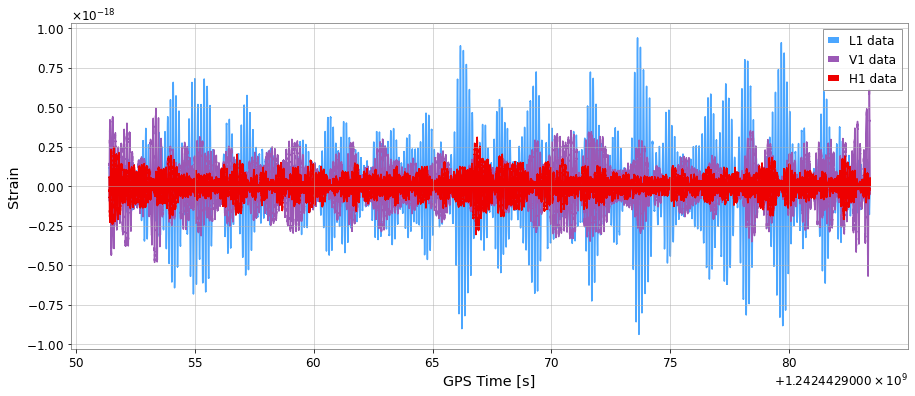

In [ ]:
plt.figure(figsize=[15,6])
colours = ['gwpy:ligo-livingston','gwpy:virgo','gwpy:ligo-hanford']
for ifo,colour in zip(ifos,colours):
  plt.plot(data[ifo],color=colour,label='{} data'.format(ifo))
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

### PSD of our data

The Power Spectrum density is calculated using the pycbc function psd with a fftlength of 4. This value was chosen because its used widely in the provided notebooks. This function calculates the following:
$$
S_x(f) = \lim_{T \to \infty } \frac{2}{T}\left|\int_{T/2}^{-T/2}x(t)e^{-2\pi i f t}dt \right|^{1/2},
$$
where $x(t)$ is the time domain data, and $S_x(f)$ is the power spectrum density created by this forier transform.

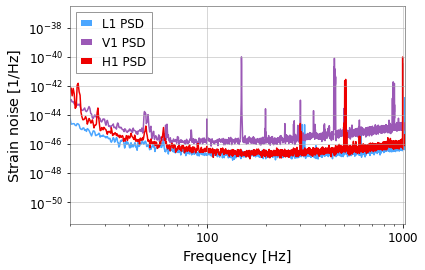

In [ ]:
psd = {}
for ifo in ifos:
  psd[ifo] = data[ifo].psd(fftlength=4)

for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

### Whitening the data

This data below is now whitened using an asd calculated from the PSD just the square root of the psd. This is then windowed with the tukey widow, this is a cosine-tapered window, this function tapers the data to zero at either end. This was used because of its frequency within the notebooks, along with the overlap of 2. By limiting the x axis to ±0.2 from the time of the event, we can see the event more clearly. 

the bandpass was limited to 50-100 Hz because this is around the signals frequency as mentioned in [7]. The overlap has been set to 2, because this is frequently used in the notebooks.

(1242442967.2, 1242442967.7)

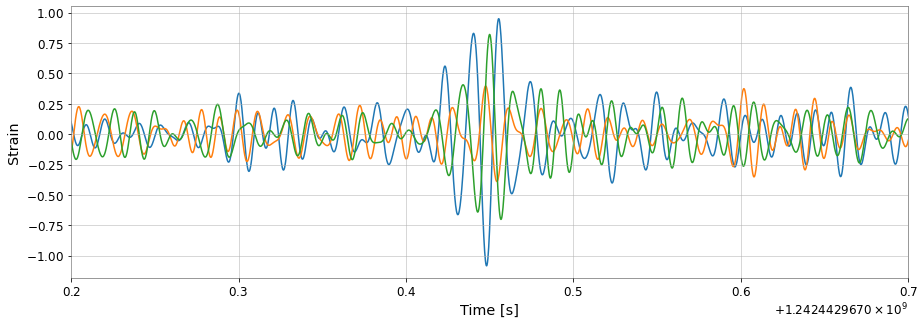

In [ ]:
white_data = {}
data_2 = {}
plt.figure(figsize = [15,5])
for ifo in ifos:
  data_2[ifo] = data[ifo].crop(time_center -2,time_center+2) #important to size corectly!
  white_data[ifo]=data_2[ifo].whiten(asd=np.sqrt(psd[ifo]),
                                     overlap=2,
                                     window=('tukey',1./4.)).bandpass(50,100) 
  plt.plot(white_data[ifo])
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.xlim(time_center-0.2,time_center+0.3)

Notice here that the detectors all have varying amplitudes this could be due to two things. The position of the gravitational wave source in respect to the detectors position and the sensitivity of the detectors. Considering that the noise part of the data here looks mostly the same, the detectors are likely to be similary as sensitive and this is confirmed by looking at the psd, where the virgo data is the most insensitive. To determine the effect of the gravitational wave orientation compared to the detectors, we can look at the antenna pattern of the detectors. Notice that this requires right ascension and declination of the GW source, since this is not specified in the detection paper. These values where taken from the analysis later. The resulting coefficients fp and fc, show that the virgo detector has the lowest amplitude because of its orientation. Where as both ligo detectors are more orientated to this GW sources direction.

In [ ]:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

In [ ]:
## Lets calcualte the beam patterns for the detectors, using the values calculate in later sections
declination = -9.42559331e-01 
right_ascension =  3.44489530e-01 
polarization = 7.16713471e-02

fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination, polarization, time_center)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.8690145847825229, fc=0.28737734552269056
V1: fp=0.14787219300794885, fc=-0.5436734742281462
H1: fp=-0.9097014143421356, fc=-0.1451979427529918


## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source. 
- Compute the overlap between those those two signals, and try to find parameters that maximises that overlap.

NOTE: remember that gravitational-wave are redshifted.

\\

### Generating CBC Waveform

To generate the CBC waveform, I have used the approximant SEABNRv4_opt, this is a model for coalescing binary black holes. So it does not model tidal effects since Black holes can be thought of as point like. The parameters we have put into this model are mass of both objects, distance to the GW source, phase of the wave. Delta t was set to the same as the data, f_lower will be kept at 50 since the waveform we are modelling is expected to be within the range 50-100Hz. The wave form is resized to the same as the data. This merger point is then shifted based on the time delay between detectors, and a fudged shift of 0.0215s was added to make sure that the waves forms line up correctly. The plot below of the whitened waveform and the whitened data is shown in the plot below.

The parameters were taken from the initial detection paper. And the masses have been changed with the GW sources redshift. The other parameters are the best fit parameters that where calculated later on in this analysis.


In [ ]:
def gen_cbc(param,
                 delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 f_lower=50.):
    
    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower) 
    
    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    ht = {}
    template = {}
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time) + 0.0215 #fudge factor
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay) 
        ht[ifo].start_time=start_time
    
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

No handles with labels found to put in legend.


(1242442967.2, 1242442967.6000001)

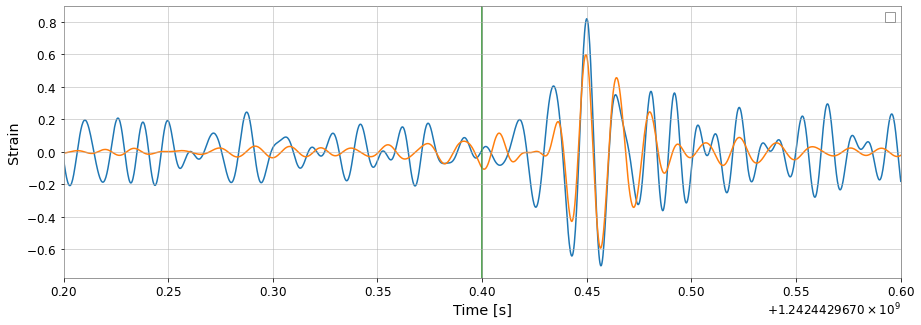

In [ ]:
param=[85*(1+0.82),66*(1+0.82),5000,float(time_center),0.0,3.44489530e-01,-9.42559331e-01 , 1.57079632e+00, 7.16713471e-02]

template_cbc = gen_cbc(param)
plt.figure(figsize=(15,5))

plt.plot(white_data['H1'])
plt.plot(template_cbc['H1'].whiten(asd=np.sqrt(psd['H1']),overlap=2,window=('tukey',1./4.)).bandpass(50,100))
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.2,time_center+0.2])

(1242442967.2, 1242442967.6000001)

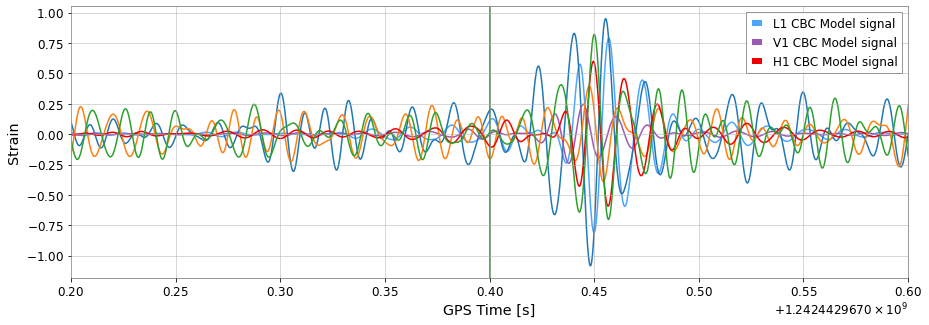

In [ ]:
param=[85*(1+0.82),66*(1+0.82),5000,float(time_center),0.0,3.44489530e-01,-9.42559331e-01 , 1.57079632e+00, 7.16713471e-02]

template_cbc = gen_cbc(param)
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.plot(template_cbc[ifo].whiten(asd=np.sqrt(psd[ifo]),overlap=2,window=('tukey',1./4.)).bandpass(50,100),label='{} CBC Model signal'.format(ifo),color=colour)
    plt.plot(white_data[ifo])
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.2,time_center+0.2])

### Burst (Phenomological) Model

To calculate the Burst model, I have used a gaussian pulse model (gaussian modulated sinusoid), this was chosen because the waveform here looks like the shape of a gaussian pulse. To allow for the same analysis steps as the cbc waveform model above I have used the .add_custom_waveform function to add this waveform to be used as a cbc generated waveform. This model has 3 parameters A the amplitude, fc the central frequency and bw is the fractional bandwidth in the frequency domain. It is expressed by the following equation:
$$
g = A e^{-at^{2}}e^{i\pi f_{c}t}
$$
Notice that this waveform also required a time shift. These two waveforms are difficult to overlap, but seem to be maximized with the parameters shown below. This gives us an idea as to the best initial parameters for the burst signal when we look for the best fit.

In [ ]:
def gauss_waveform(**args):
    import numpy
    from pycbc.types import TimeSeries
    from scipy.signal import gausspulse
    flow = args['f_lower']
    dt = args['delta_t']
    A = args['A']
    fc = args['fc']
    bw = args['bw']
    min = args['min']
    max = args['max']
    
    t = numpy.arange(min, max, dt)

    guass_pulse = gausspulse(t,fc,bw)*A

    offset = - len(t) * dt
    guass_pulse = TimeSeries(guass_pulse, delta_t=dt, epoch=offset)
    return guass_pulse.real(), guass_pulse.imag()

In [ ]:
pycbc.waveform.add_custom_waveform('gauss', gauss_waveform, 'time', force=True)

In [ ]:
def gen_burst(param,time_diff,
              delta_t=data['H1'].dt.value, 
              duration=data['H1'].duration.value, 
              start_time=data['H1'].x0.value,
              f_lower=50.):
  
  A,fc,bw = param

  hp,hc = pycbc.waveform.get_td_waveform(approximant='gauss',
                                         delta_t=delta_t,
                                         f_lower=f_lower,
                                         A=A,
                                         fc=abs(fc),
                                         bw=abs(bw),
                                         min=-0.2, #this just set the inital size (changes with resizing)
                                         max=0.2)  
  # Resize the signal
  hp.resize(int(duration/delta_t))
  hc.resize(int(duration/delta_t))
  
  ht =  hp.copy() +  hc.copy()
        
  time_delay = 0.2+np.float(time_diff) 
        
  ht = ht.cyclic_time_shift(ht.start_time + time_center - start_time + time_delay) 
  ht.start_time=start_time
    
  template=TimeSeries.from_pycbc(ht)
  
  return template

  

(1242442967.2, 1242442967.6000001)

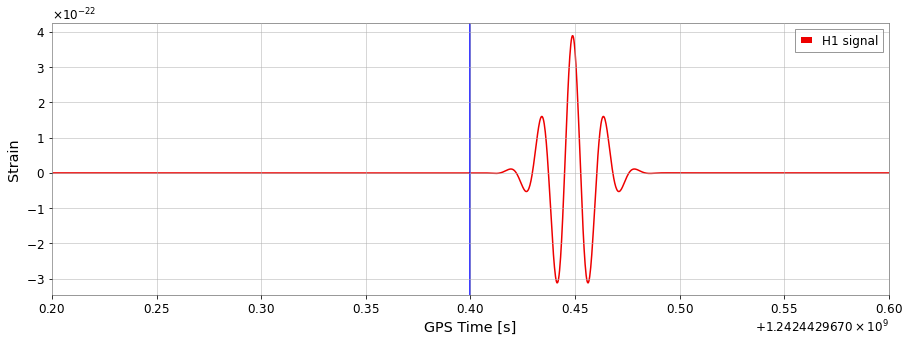

In [ ]:
A = 3.9E-22
fc = 65
bw =0.51
time = time_center
time_diff = 0.049
param = [A,fc,bw]

template_b = gen_burst(param,time_diff)
plt.figure(figsize=(15,5))
plt.plot(template_b,label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='blue')
plt.xlim([time_center-0.2,time_center+0.2])

(1242442967.2, 1242442967.6000001)

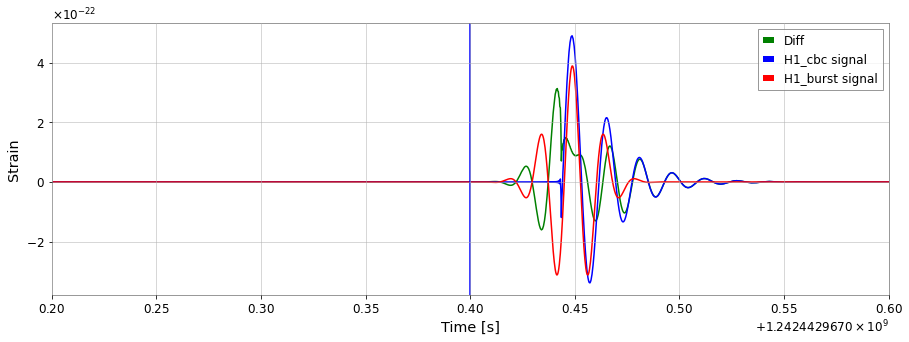

In [ ]:
plt.figure(figsize=[15,5])
diff_H1 = template_cbc['H1'] - template_b 
plt.plot(diff_H1,label='Diff',color = 'green')
plt.plot(template_cbc['H1'],label='H1_cbc signal',color='Blue')
plt.plot(template_b,label='H1_burst signal',color='Red')

plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='blue')
plt.xlim([time_center-0.2,time_center+0.2])

(1242442967.2, 1242442967.6000001)

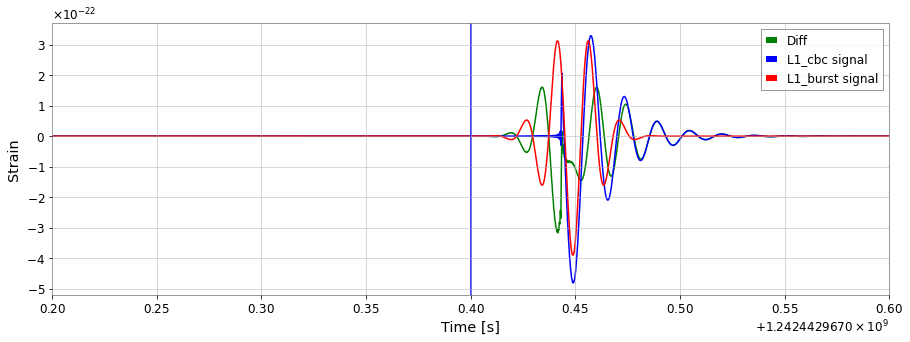

In [ ]:
plt.figure(figsize=[15,5])
A = -3.9E-22
fc = 65
bw =0.51
time = time_center
time_diff = 0.049
param = [A,fc,bw]
template_b = gen_burst(param,time_diff)
diff_H1 = template_cbc['L1'] - template_b 
plt.plot(diff_H1,label='Diff',color = 'green')
plt.plot(template_cbc['L1'],label='L1_cbc signal',color='Blue')
plt.plot(template_b,label='L1_burst signal',color='Red')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='blue')
plt.xlim([time_center-0.2,time_center+0.2])

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

\\

Here I compute the SNR time series of with both models and give the highest SNR. The SNR analysis steps are shown below:


In [ ]:
def SNR_gen(data,psd,template):
  data_2 = data.crop(time_center-16,time_center+16)
  y = template
  #created data fourier transform.
  data_ft= data_2.average_fft(window=('tukey',1./4.))*(data_2.duration/2)
  #creates template fourier transfrom.
  template_ft = y.average_fft(window=('tukey',1./4.))*(y.duration/2)
  #calculate psd for data
  Psd_data = data.psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)
  Psd_2 = Psd_data.interpolate(data_ft.df.value)
  #calculate eqn 7.58 from text book
  optimal= data_ft*template_ft.conjugate()/Psd_2
  opt_time = 2*optimal.ifft()*(optimal.df*2)
  #calculate sigma
  sigmasq = 4* np.real((template_ft *template_ft.conjugate()/Psd_2).sum() * template_ft.df)
  sigma = np.sqrt(np.abs(sigmasq))
  #calculating SNR
  SNR_complex = opt_time/sigma
  peaksample = y.argmax()
  SNR_complex = np.roll(SNR_complex,peaksample)
  SNR = abs(SNR_complex)
  #calculating the max SNR
  SNRmax = SNR.max().value
  time_max=SNR.times[SNR.argmax()]
  print('Maximum SNR of {} at {}.'.format(SNRmax,time_max)) #reported SNR was 14-15.
  plt.plot(SNR)
  return SNR


Here we see that the highest SNR is 9.92 and 10.19, for the cbc and burst models respectfully. These SNRs are lower than the SNR quoted in the discovery paper, the reason for this is somewhat unknown but a possible answer is the use of different approximant to generate the waveform.
 The differences between the two SNR is only small, this implies that the two waveforms are similar.

The discovery paper [7] reports a SNR of 14.5, which is larger than any value determined here. The reason for this is unclear, but it is still a significant detection.

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)
/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)
/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Maximum SNR of 9.91850863653305 at 1242442967.4401853 1 / Hz.
Maximum SNR of 4.965509652855568 at 1242442977.8776853 1 / Hz.
Maximum SNR of 7.2825548429347835 at 1242442967.4335935 1 / Hz.


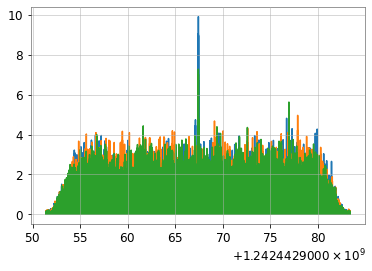

In [ ]:
SNR = {}
for ifo in ifos:
  SNR[ifo] = SNR_gen(data[ifo],psd[ifo],template_cbc[ifo])

/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)
/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)
/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:931: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Maximum SNR of 10.193367336487507 at 1242442967.455322 1 / Hz.
Maximum SNR of 4.230548797699371 at 1242442967.4545896 1 / Hz.
Maximum SNR of 7.403438685025706 at 1242442967.4572752 1 / Hz.


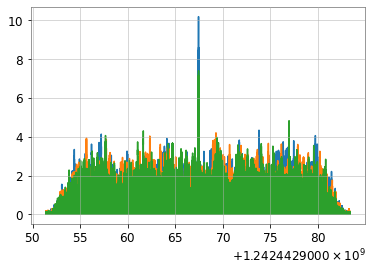

In [ ]:
for ifo in ifos:
  SNR_gen(data[ifo],psd[ifo],template_b)

To be confindent that we have made a graviational wave detection, we need to beable to estimate the false alarm rate. This will give the likelihood of the observed signal being random noise. We can estimate this by calculating the p-value of the SNR peak. Since for H1 and L1 we have no other peaks in our data, the pvalue return will be 0. This means that the signal is significant, but we cannot exactly say how significant. If we look at the Virgo data we can estimate a upper bound on the signals pvalue since their are many peaks in this data.

In [ ]:
window_size = int((1) / SNR['V1'].dt.value)
sidx = int((float(-0.25+time_center-SNR['V1'].x0.value)) / SNR['V1'].dt.value)
eidx = sidx + window_size

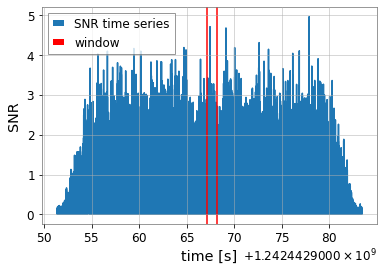

In [ ]:
plt.plot(SNR['V1'],label='SNR time series')
plt.axvline(SNR['V1'].times[sidx].value,c='r',label='window')
plt.axvline(SNR['V1'].times[eidx].value,c='r')
plt.xlabel('time [s]')
plt.ylabel('SNR')
plt.legend();

In [ ]:
onsource = SNR['V1'][sidx:eidx].max()

In [ ]:
peaks = []
i = 0
while i + window_size < len(SNR['V1']):
    p = SNR['V1'][i:i+window_size].max()
    peaks.append(p)
    i += window_size
    if abs(i - sidx) < window_size:
        i += window_size * 2   
peaks = np.array([p.value for p in peaks])

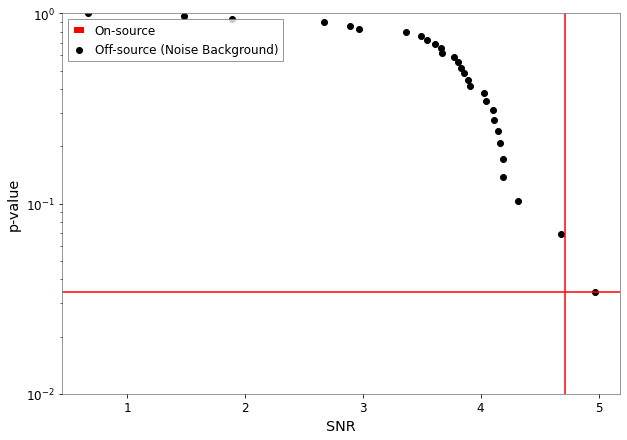

The p-value associated with the GW190521 peak is 0.034482758620689655


In [ ]:
pcurve = np.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()
pvalue = (peaks > onsource.value).sum() / float(len(peaks))
plt.figure(figsize=[10, 7])
plt.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')
plt.axvline(onsource.value, label='On-source', color='red')
plt.axhline(pvalue, color='red')
plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, 1e0)
plt.ylabel('p-value')
plt.xlabel('SNR')
plt.show()

print("The p-value associated with the GW190521 peak is {}".format(pvalue))

This mean that the probalilty of a SNR like this in the virgo data is 0.034. which is also known as the false alarm probablilty. This has only been done for the CBC model, there is no need to repeat this for the burst model since the SNRs are very similar and this is only an estimate.

## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build a likelihood, prior and posterior function for the network of gravitational-wave detectors.
- Maximise that function and plot the relevant quantities.
- Interface that posterior function with a sampling algorithm (you are free to select any ready-made algorithm).
- Perform the sampling, and plot the results.
- Redo the steps above with the Burst model.
- Compare the results and discuss.

\\


### Posterior Probablity Function

The posterior probablity for a set of source parameters $\theta$, given a data segment $d$ is expressed below as an adaption of bayes theorem.

$$
p(\theta|d,M) \propto \pi(\theta)L(d|\theta,M)
$$

Where $L$ is the frequency donamin likelihood used for the graviational wave transient signals [8]. And $\pi(\theta)$ is the prior, this will be further desciped for each model later.

$$
log  L(d|\theta,M) = -\frac{1}{2}(d-h_{M}(\theta)|d-h_{M}(\theta)),
$$

Where, $h_{M}(\theta)$ denotes the waveform model for parameters $\theta$. the operation (a|b) denoted the inner product as:

$$
(a|b) = 4 Re \int_{f_{min}}^{f_{max}} \frac{\tilde{a}(f) \tilde{b}(f)}{S_{n}(f)} df.
$$

Here $S_{n}(f)$ is the power spectrum density as expressed above.

For a network of detectors, we need to add the likelihood of each detector to form the posterior.

$$
log L_{net} = \sum_{i \in \{H1,L1\}} log L_{i}
$$

### CBC Best fit and sampling

In [ ]:
ifos = ['L1','H1'] #since we are now not using the Virgo data

In [ ]:
param=[85*(1+0.82),66*(1+0.82),5000,float(time_center),0.0,3.44489530e-01,-9.42559331e-01 , 1.57079632e+00, 7.16713471e-02]
# the parameters above where selected based on the detection paper and the ra and dec where taken from the best fit to the data.
#m1,m2,distance,time,phase,ra,dec,inclination,polarization.

In [ ]:
sf={}
for ifo in ifos:
    sf[ifo] = data_2[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2

In [ ]:
def loglikelihood(param,sf=sf,f_lower=50.0):
  
  hf_hp = {}
  logl=0.0
  template = gen_cbc(param)
  
  for ifo in ifos:
    template[ifo] = template[ifo].crop(time_center-2,time_center+2)
    sf_hp = sf[ifo].crop(start=f_lower)
    psd_hp = psd[ifo].crop(start=f_lower)
        
    hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
    hf_hp = hf.crop(start=f_lower)
    #calculating the inner product.
    h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
    h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

    logl += h_dot_s - h_dot_h/2   #adds all detector likelihoods.

  return logl.value

print(loglikelihood(param))

811.7964431367268


#### CBC Model Priors

It is important here to select appropriate priors. These need to incorporate our prior knowledge of the wave form.

Here we will incorperate the limts of certain parameters:
$ra$, $phase$, $polarization$ $\in [0,2\pi]$. We also know that we will not have any negative distances. $Inclination \in [0,\pi]$, $dec \in [-\pi/2,\pi/2]$. We also know that the masses cannot be smaller than 0.

Note that I have an additional distance prior [4000, 6000] this prior does bias the anaysis, but with out this the minimize funtion will make the distance really small even if the funtion clearly is a worse fit with it. This prior is also in the range of the dectetion paper distance so it shouldnt be too restricitve.

All but dec, distance and inclination (i) have uniform priors.
These parameters do not have a uniform prior, we use the following priors.

$$
p(ra,dec) \propto cos(dec),
$$
$$
p(D,i) \propto D^{2} sin(i)
$$

In [ ]:
def logprior(param):
    logp = 0
    m1, m2, distance, time, phase, ra, dec, inclination, polarization= param
    
    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    if distance < 4000 or distance > 6000:
        return -np.inf
    if m1 < 0:
      return -np.inf
    if m2 < 0:
      return -np.inf
    logp += np.log(np.cos(dec)) 
    logp += 2*np.log(distance)  
    logp += np.log(np.sin(inclination))
    return logp

In [ ]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [ ]:
logposterior(param)

828.2993236717623

In [ ]:
white_data = {}
for ifo in ifos:
  white_data[ifo] = data[ifo].whiten(asd=np.sqrt(psd[ifo])).bandpass(50,100)

(1242442967.2, 1242442967.6000001)

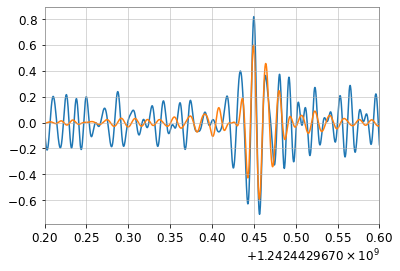

In [ ]:
white_template = {}
template_cbc = gen_cbc(param)
for ifo in ifos:
  white_template[ifo] = template_cbc[ifo].whiten(asd=np.sqrt(psd[ifo])).bandpass(50,100)
plt.plot(white_data['H1'])
plt.plot(white_template['H1'].crop(time_center-2,time_center+2))
plt.xlim(time_center -0.2,time_center+0.2)

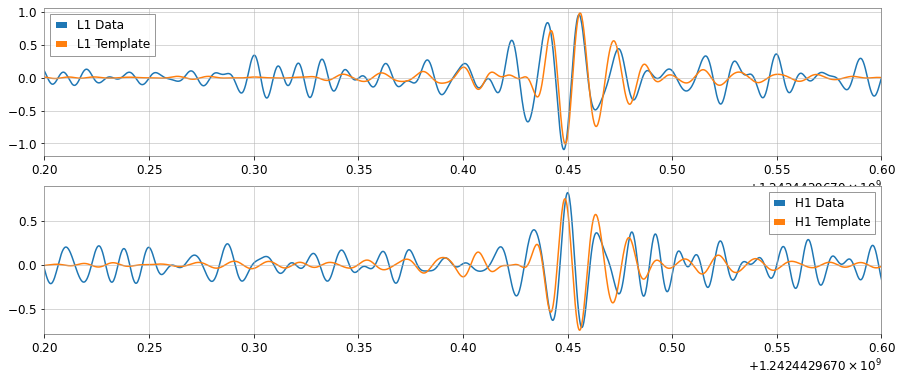

Steps	log(posterior)
11	1151.720


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
template_cbc = gen_cbc(param)
lines = {}
for ax, ifo in zip(axs, ifos):
    white_template = template_cbc[ifo].whiten(asd=np.sqrt(psd[ifo])).bandpass(50,100)
    ax.plot(white_data[ifo].times, white_data[ifo], label="{} Data".format(ifo))
    lines[ifo], = ax.plot(white_template.times, white_template, label="{} Template".format(ifo))

    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_cbc(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo])).bandpass(50,100)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -logposterior(param), param, callback=callback, method='powell')
plt.close()


In [ ]:
best_fit = res.x
print(res.x)

[ 1.55532431e+02  1.20138669e+02  4.00000000e+03  1.24244297e+09
  2.47163176e-05  3.12837992e-01 -9.41968079e-01  1.57079632e+00
  1.06316481e-01]


Looking at the plot above we can see that the parameters appear to be a good fit to the data. Notice that for the best fit, the distance is right against the lower limit of its prior, This problem does not happen in the sampling below. As mentioned before this prior limit is so that the algorithm above does not run away with smaller and smaller D.

The timing isnt perfect, the model does not perfectly overlap both signals. Changing the fudged time shift would not do this since the time shifts would have to be in different directions.

#### MCMC Sampling

the sampling here is done useing the Emcee package/libary. This samples the probality space with walkers. To start the algorthm we need to specify the starting positions in the parameters space for all walkers. This is done with parameter p0. This is where we can choice an approiate step size for each parameter.

In [ ]:
nwalkers = 500
initial = np.array(best_fit) 
ndim = len(initial) 

#controls stepsize
p0 = [np.array([initial[0] + 10*np.random.random_sample(),
                 initial[1] + 10*np.random.random_sample(),
                  initial[2] + 1000*np.random.random_sample(),
                  initial[3] + np.random.random_sample(),
                  initial[4] + 0.5*np.random.random_sample(),
                  initial[5] + np.random.random_sample(),
                  initial[6] + np.random.random_sample(),
                  initial[7] + np.random.random_sample(),
                  initial[8] + 0.5*np.random.random_sample()]) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
sampler.run_mcmc(p0,20) #small iteration number but long to calculate. single sampler number is 10,000. (500x20)

State([[ 1.61064570e+02  1.23683210e+02  4.33734223e+03 ...
  -3.03501645e-01  2.11489639e+00  5.69500602e-01]
 [ 1.64193568e+02  1.33621399e+02  5.79908977e+03 ...
  -8.22576842e-01  1.65435447e+00  8.18937176e-03]
 [ 1.62144514e+02  1.28369010e+02  4.27783636e+03 ...
   4.92772746e-02  1.78886792e+00  4.02699073e-01]
 ...
 [ 1.62724844e+02  1.27704462e+02  5.00741004e+03 ...
  -7.32725368e-01  2.09501354e+00  5.12270742e-01]
 [ 1.57032755e+02  1.28340714e+02  4.67217739e+03 ...
  -9.15781509e-01  1.99603958e+00  4.21475429e-02]
 [ 1.63392427e+02  1.29242004e+02  4.72346933e+03 ...
  -1.12284411e-01  2.02257409e+00  3.65082280e-01]], log_prob=[119.65678684  11.23774885 242.14064105 ... 125.81938103
  74.79489589 139.38727816], blobs=None, random_state=('MT19937', array([ 587909588, 1311317606, 3686882760, ..., 3691421926,
        946386848, 1220187370], dtype=uint32), 60, 0, 0.0))

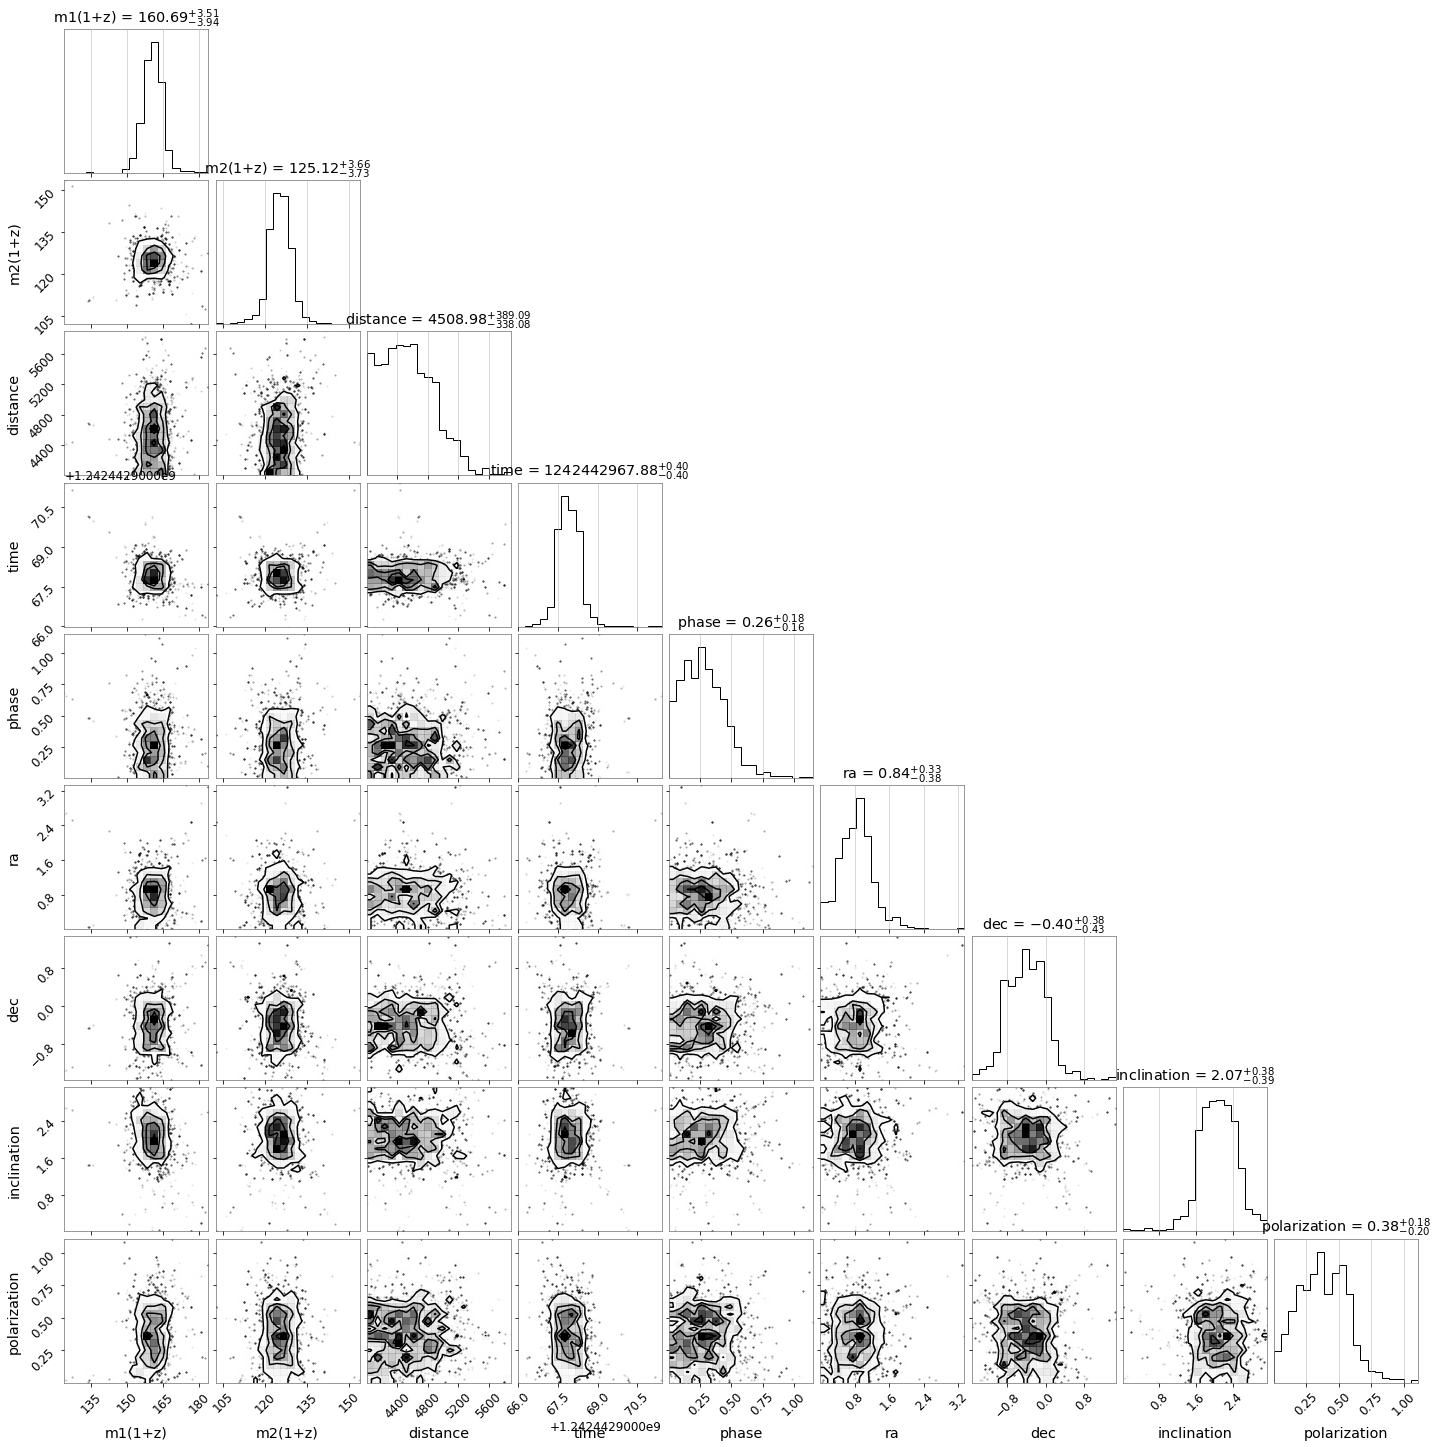

In [ ]:
samples = sampler.flatchain
labels=['m1(1+z)', 'm2(1+z)', 'distance', 'time', 'phase', 'ra', 'dec', 'inclination', 'polarization']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True)

The results above show the posterior distributions for all the 9 parameters. 

### Burst Best fit and Sampling

In [ ]:
def loglikelihood_b(param,ifo,time_diff,sf=sf,f_lower=50.0):
  
  hf_hp = {}
  logl=0.0
    
  template = gen_burst(param,time_diff).crop(time_center-2,time_center+2)
  
  # zero out the frequencies below f_lower
  data_c = data[ifo].crop(time_center -2,time_center+2)
  sf = data_c.average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2

  sf_hp = sf.crop(start=f_lower)

  psd_hp = psd[ifo].crop(start=f_lower)
     
  hf = template.average_fft(window=('tukey',1./4.))*template.duration.value/2

  hf_hp = hf.crop(start=f_lower)

  #calculating the inner product.
  h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
  h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

  logl += h_dot_s - h_dot_h/2

  return logl.value

#### Burst Model Priors

We have 3 parameters descriping our guassian pulse model. These have been set to uniform priors within the following limit:

$$
1<fc<100,
$$
$$
0.2<bw<0.9.
$$

These parameters where chosen because they limit the sample space to parameters we know it must be close too. Without these limts the parameters will not behave nicely when the posterior is maximized.

In [ ]:
def logprior_b(param):
    logp = 0
    A, fc, bw = param
    #if A < 0:
    #  return - np.inf
    if fc < 1 or fc > 100: 
      return - np.inf
    if bw < 0.2 or bw > 0.9:
      return - np.inf
  
    return 1

#### H1 Finding best fit

In [ ]:
def logposterior_b(param,ifo,time_diff=0.049):
    logpost = logprior_b(param)
    if np.isfinite(logpost):
        logpost += loglikelihood_b(param,ifo,time_diff)
    return logpost

In [ ]:
A = 3.5E-22
fc = 65
bw =0.51
time_diff = 0.049
param = [A,fc,bw]
print(logposterior_b(param,'H1'))

328.9541681814901


328.9541681814901


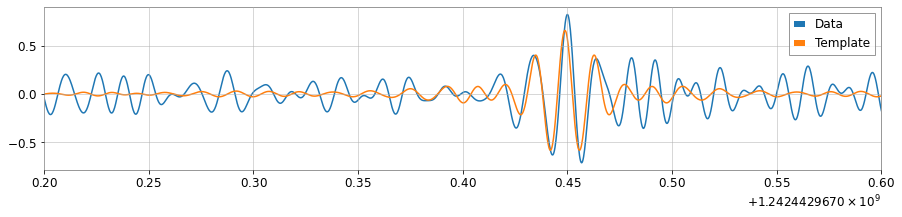

In [ ]:
template = gen_burst(param,time_diff)

white_template = template.whiten(asd=np.sqrt(psd['H1'])).bandpass(50,100)
plt.figure(figsize=[15, 3])
plt.plot(white_data['H1'], label="Data")
plt.plot(white_template, label="Template")

plt.xlim(time_center-.2, time_center+.2)
plt.legend();
print(logposterior_b(param,'H1'))

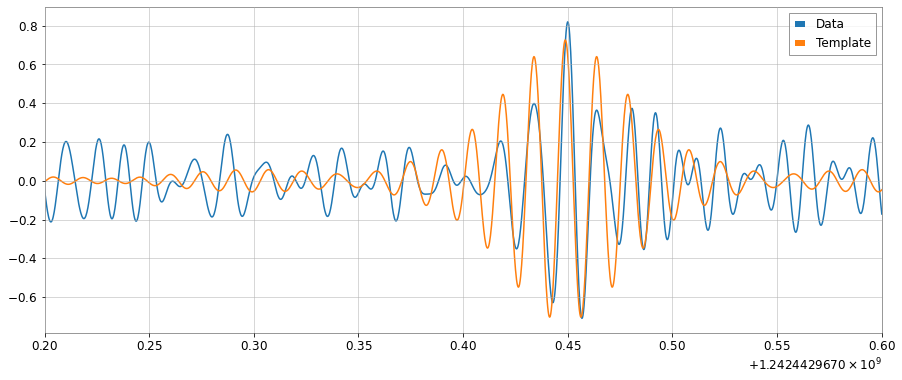

Steps	log(likelihood)
3	511.064


In [ ]:
fig = plt.figure(figsize=[15, 6])
Neval = 1


plt.plot(white_data['H1'], label="Data")
lines, = plt.plot(white_template.times, white_template, label="Template")

plt.xlim(time_center-.2, time_center+.2)
plt.legend()


def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_burst(param_i,time_diff)
    
    white_template = template.whiten(asd=np.sqrt(psd['H1'])).bandpass(50,100)
    lines.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, logposterior_b(param_i,'H1')))
    
    Neval += 1
    
res = minimize(lambda param: -logposterior_b(param,'H1'), param, callback=callback, method='powell')
plt.close()

#### H1 MCMC sampling

In [ ]:
best_fit = res.x
print(best_fit)
best_fit_template = gen_burst(best_fit,time_diff)

[3.50000000e-22 6.47937247e+01 2.00000028e-01]


In [ ]:
nwalkers = 500
initial = np.array(best_fit)
ndim = len(initial)

p0 = [np.array([initial[0] + 1E-24*np.random.random_sample(),
                initial[1]+np.random.random_sample(),
                0.05*initial[2]+np.random.random_sample()]) for i in range(nwalkers)]


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior_b,args=['H1'])
sampler.run_mcmc(p0,10)

/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[3.50594147e-22 6.58714786e+01 2.55818109e-01]
 [3.50717975e-22 6.48009550e+01 2.49420590e-01]
 [3.50920595e-22 6.42338360e+01 2.31831606e-01]
 ...
 [3.50384864e-22 6.55213168e+01 6.05776105e-01]
 [3.50266194e-22 6.55308453e+01 5.39420469e-01]
 [3.50112083e-22 6.55205518e+01 3.96724654e-01]], log_prob=[464.49966234 476.82232699 490.92363557 ... 293.84175887
 316.7779641  377.63470611], blobs=None, random_state=('MT19937', array([3248547911,  243879311, 3552549573, ..., 2303735506,
       3774283694, 2517743704], dtype=uint32), 368, 0, 0.0))

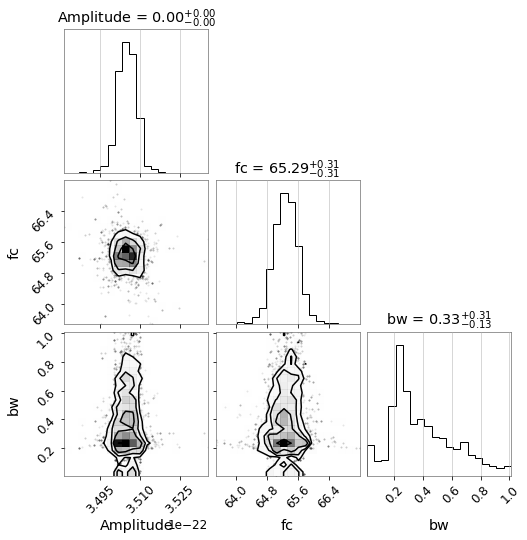

In [ ]:
samples = sampler.flatchain
labels=['Amplitude', 'fc', 'bw']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True)

#### Fit and MCMC for L1 data

In [ ]:
A = -3.5E-22
fc = 65
bw =0.51
time_diff = 0.048 #notice the difference
param = [A,fc,bw]
print(logposterior_b(param,'L1'))

583.6489919281628


638.7586683051944


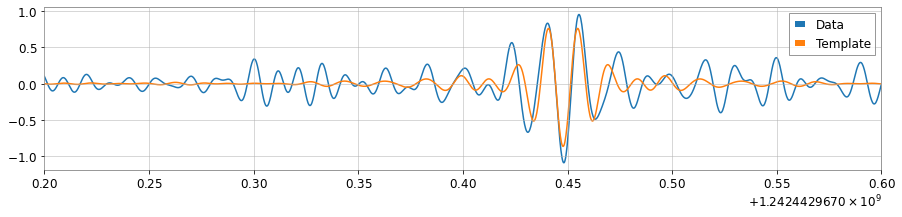

In [ ]:
template = gen_burst(param,time_diff)

white_template = template.whiten(asd=np.sqrt(psd['L1'])).bandpass(50,100)
plt.figure(figsize=[15, 3])
plt.plot(white_data['L1'], label="Data")
plt.plot(white_template, label="Template")

plt.xlim(time_center-.2, time_center+.2)
plt.legend();
print(loglikelihood_b(param,'L1',time_diff=time_diff))

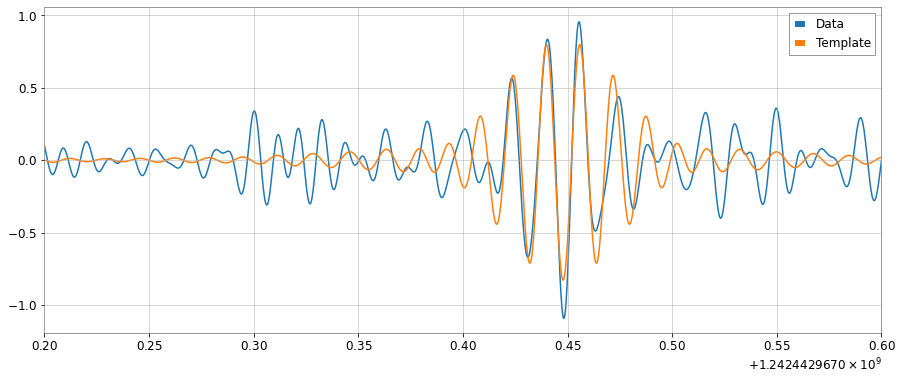

Steps	log(likelihood)
3	932.250


In [ ]:
fig = plt.figure(figsize=[15, 6])
Neval = 1


plt.plot(white_data['L1'], label="Data")
lines, = plt.plot(white_template.times, white_template, label="Template")

plt.xlim(time_center-.2, time_center+.2)
plt.legend()


def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_burst(param_i,time_diff)
    
    white_template = template.whiten(asd=np.sqrt(psd['L1'])).bandpass(50,100)
    lines.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, logposterior_b(param_i,'L1')))
    
    Neval += 1
    
res = minimize(lambda param: -logposterior_b(param,'L1',time_diff=time_diff), param, callback=callback, method='powell')
plt.close()

In [ ]:
best_fit = res.x
print(best_fit)
best_fit_template = gen_burst(best_fit,time_diff)

[-3.50000000e-22  6.12133596e+01  2.00000028e-01]


In [ ]:
nwalkers = 500
initial = np.array(best_fit)
ndim = len(initial)

p0 = [np.array([initial[0] + 1E-24*np.random.random_sample(),
                  initial[1]+np.random.random_sample(),
                  0.05*initial[2]+np.random.random_sample()]) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior_b,args=['H1'])
sampler.run_mcmc(p0,10)

/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[-3.49140143e-22  6.16901422e+01  5.79746465e-02]
 [-3.49912499e-22  6.23150043e+01  8.48582560e-01]
 [-3.48992298e-22  6.13366401e+01  8.23438427e-01]
 ...
 [-3.47813365e-22  6.08809974e+01  4.68209452e-01]
 [-3.49350464e-22  6.13613034e+01  8.95397187e-01]
 [-3.49692433e-22  6.17415691e+01  8.36141350e-01]], log_prob=[         -inf -257.1553062  -262.94666575 ... -383.57104351
 -246.44438507 -260.30530886], blobs=None, random_state=('MT19937', array([ 783756680, 1937376062, 1331857408, ..., 2484421877,
       1817181545, 3648408246], dtype=uint32), 358, 0, 0.0))

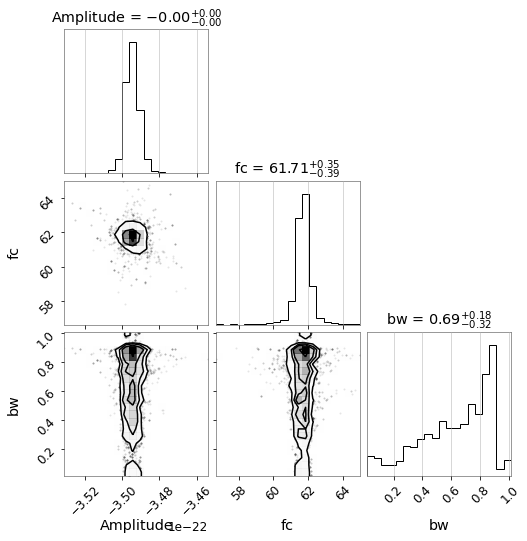

In [ ]:
samples = sampler.flatchain
labels=['Amplitude', 'fc', 'bw']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True)

### Discussion

In this analysis Ideally, we would like to have constrained the right ascension and declination of the event better. This would have required the use of the virgo data. But this failed to be constructive in looking for the best fit to the models, so to improve the fit to the Ligo detectors it was removed from the analysis. Improving the sampling space of MCMC would have made the posterior distributions more convincing, but due to the large amount of time to compute it was decided that this would be sufficent for this analysis.

The burst model and the CBC model are fundamentally different. The CBC model assumes that the signal is from a Compact binary coalescence (and its wavefrom is derived from that model). the burst model doent assume anything about the source, it mearly is there to describe as best it can the parameters of the waveform and not of the source creating it. Therfore the burst model and the cbc model allows us to see different parameters.

The Burst parameters for L1 and H1 differ in an expected way. The amplitudes are similar in magnitude but with one negative and the other positive. The parameter fc is also similar, which shows similarity in the two detectors signals. A noticeble difference in the Burst parameters is in the bw (bandwidth) value, For L1 $bw = 0.69_{-0.32}^{+0.18}$ compared to H1 $bw = 0.33_{+0.31}^{-0.13}$. The reason for this is unkown.


## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW190521, including relevant citations from the literature, and summarising them.

\\

The analysis presented in the notebook has put some constraints on the parameters of the merging binary black holes and their sky localization along with their distance. Its is important to discuss the estimates here with those from other papers. The discovery paper for GW190521 [7], these parameters are shown in the table below along with the estimated parameters determined here. The CBC model assumes the gravitational wave is from a compact binary merger, if that’s true then the properties of that merger is shown in the table.

|Parameter|This Notebook | Detection paper [7]  |
------------------------ | --------- | ---------
|$m_1(1+z) (\mathbf{M}_{\bigodot})$|$160.7_{-3.9}^{+3.5}$|$154.0_{-50.0}^{+67.9}$|
|$m_2(1+z)(\mathbf{M}_{\bigodot})$|$125.1_{-3.7}^{+3.7}$|$120.0_{-49.1}^{+54.2}$|
|Luminosity Distance ($\mathbf{Mpc}$)|$4508_{-338}^{+389}$|$5300_{-2600}^{+2400}$|

Here we can see that the parameters are consistent and overlap with their errors. The most interesting difference here is the magnitude of the errors on the parameters generated in this notebook compared to the detection paper. This is likely due to a number of things. One is that the model used in [7] is different to the one used in this analysis. It uses multiple models the main one being NRSur7dq4, which is described further in [8] but essentially models uneven mass black hole binaries. This difference can lead to different fits to the data, and lead to the MCMC algorithm sampling a different probability space, leading to alternative parameters. However, since the values are similar suggests reliability in both models.  

The most popular interpretation of the event is that of it being cause by the merger of two large black holes. And there is no evidence here to suggest anything otherwise. Alternative interpretations of GW190521 all assert that according to stellar evolution, Black holes of this mass cannot be formed from the collapse of a star [10]. Investigations have been done looking into whether the progenitors of this merger could have been created from relativistic accretion. Being that the objects grew to their merger size due to accretion and where initially formed as lower masses [11].  Cruz-Osorio et al, found that through simulations of this accretion, it is possible to create black holes with similar mass and spin for only for scenarios with high Mach numbers in the accreting plasma. This makes the argument that the origins of this event to be from two black hole merger to be increasingly likely. It has been suggested that the origins of this merger however has other origins, this idea comes from the fact that there is a barely visible pre-merger emission. Bustillo et al, [12] showed that the signal is consistent with a head-on collision of two horizonless vector boson star and finalising in a black hole. It would be interesting to see if their are future detections of this type, with such large Masses which would start creating a clearer picture of what is happening to cause this signal whether that binary black hole mergers or an alternative.




## Bibliography


[1]	 J. H. Taylor and J. M. Weisberg, ‘A new test of general relativity - Gravitational radiation and the binary pulsar PSR 1913+16’, Astrophys. J., vol. 253, pp. 908–920, Feb. 1982, doi: 10.1086/159690.

[2]	 J. Aasi et al., ‘Advanced LIGO’, Class. Quantum Gravity, vol. 32, no. 7, p. 074001, Mar. 2015, doi: 10.1088/0264-9381/32/7/074001.

[3]	M. E. Gertsenshteǐn and V. I. Pustovoǐt, ‘On the Detection of Low-Frequency Gravitational Waves’, Sov. J. Exp. Theor. Phys., vol. 16, p. 433, 1963.

[4]	LIGO Scientific Collaboration and Virgo Collaboration et al., ‘GWTC-1: A Gravitational-Wave Transient Catalog of Compact Binary Mergers Observed by LIGO and Virgo during the First and Second Observing Runs’, Phys. Rev. X, vol. 9, no. 3, p. 031040, Sep. 2019, doi: 10.1103/PhysRevX.9.031040.

[5]	R. Abbott et al., ‘GWTC-2: Compact Binary Coalescences Observed by LIGO and Virgo During the First Half of the Third Observing Run’, ArXiv E-Prints, vol. 2010, p. arXiv:2010.14527, Oct. 2020.

[6]	The LIGO Scientific Collaboration and the Virgo Collaboration, ‘Observation of Gravitational Waves from a Binary Black Hole Merger’, Phys. Rev. Lett., vol. 116, no. 6, p. 061102, Feb. 2016, doi: 10.1103/PhysRevLett.116.061102.

[7]	LIGO Scientific Collaboration and Virgo Collaboration et al., ‘GW190521: A Binary Black Hole Merger with a Total Mass of $150 {M}_{\bigodot}$’, Phys. Rev. Lett., vol. 125, no. 10, p. 101102, Sep. 2020, doi: 10.1103/PhysRevLett.125.101102.

[8]	L. S. Finn, ‘Detection, measurement, and gravitational radiation’, Phys. Rev. D, vol. 46, no. 12, pp. 5236–5249, Dec. 1992, doi: 10.1103/PhysRevD.46.5236.

[9]	V. Varma et al., ‘Surrogate models for precessing binary black hole simulations with unequal masses’, Phys. Rev. Res., vol. 1, no. 3, p. 033015, Oct. 2019, doi: 10.1103/PhysRevResearch.1.033015.

[10]	A. Heger, C. L. Fryer, S. E. Woosley, N. Langer, and D. H. Hartmann, ‘How Massive Single Stars End their Life’, Astrophys. J., vol. 591, no. 1, pp. 288–300, Jul. 2003, doi: 10.1086/375341.

[11]	A. Cruz-Osorio, F. D. Lora-Clavijo, and C. Herdeiro, ‘GW190521 formation scenarios via relativistic accretion’, ArXiv E-Prints, vol. 2101, p. arXiv:2101.01705, Jan. 2021.

[12]	J. C. Bustillo et al., ‘GW190521 as a Merger of Proca Stars: A Potential New Vector Boson of 8.7 ×10-13 eV’, Phys. Rev. Lett., vol. 126, p. 081101, Feb. 2021, doi: 10.1103/PhysRevLett.126.081101.


